# Initialisation

In [12]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from preprocessing import preprocessor as prep
from styles import *

In [2]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv')
test = pd.read_csv('../02_data/application_test.csv')

id_error_msg = lambda x: '`SK_ID_CURR` is not unic for {} set!'.format(x)
assert len(train.SK_ID_CURR.unique()) == train.shape[0], id_error_msg('train')
assert len(test.SK_ID_CURR.unique()) == test.shape[0], id_error_msg('test')
train.set_index('SK_ID_CURR', inplace=True)
test.set_index('SK_ID_CURR', inplace=True)

print('Training set dimensions :', train.shape)

cls_size = train.TARGET.value_counts()
cls_freq = train.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.3f' % x)}))

Training set dimensions : (307511, 121)
     size   freq
0  282686  0.919
1   24825  0.081


In [4]:
train_sample = train[::10]
print('Sampled training set dimensions :', train_sample.shape)
cls_size = train_sample.TARGET.value_counts()
cls_freq = train_sample.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.3f' % x)}))

Sampled training set dimensions : (30752, 121)
    size   freq
0  28303  0.920
1   2449  0.080


On échantillonne le dataset en prenant 10% des points de données

In [5]:
X, y = train.iloc[:, 1:], train.iloc[:, 0]#.values.reshape(-1,1)
Xs, ys = train_sample.iloc[:, 1:], train_sample.iloc[:, 0]#.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=.2,
                                                    random_state=0)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (24601, 120)
y_train: (24601,)
X_test: (6151, 120)
y_test: (6151,)


# Rééquilibrage de classes - SMOTE/Tomek

Il y a ~8% de cas de défaut dans le jeu d'entraînement contre 92% de cas sans défaut. Le déséquilibre des classes pose problème dans le cadre de la prédiction de la classe minoritaire par un algorithme de ml.

Il faut rééquilibrer les classes du jeu d'entraînement avant de sélectionner le meilleur modèle de ml 

## Impact de SMOTE Tomek sur la répartition des classes

In [13]:
resamplr = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
udsamplr = SMOTEENN(random_state=42)
rusamplr = RandomUnderSampler(random_state=42)

In [7]:
X_train_trans = prep.fit_transform(X_train)
print(X_train_trans.shape)
print(X_train_trans)
print(y_train.shape)
print(y_train.value_counts())

(24601, 235)
[[0.         0.09011628 0.07823375 ... 1.         0.         0.        ]
 [0.         0.01162791 0.01353611 ... 0.         1.         0.        ]
 [0.         0.05232558 0.15492746 ... 0.         1.         0.        ]
 ...
 [0.         0.14244186 0.1340753  ... 0.         1.         0.        ]
 [0.1        0.12790698 0.28631022 ... 0.         0.         0.        ]
 [0.3        0.06395349 0.25047455 ... 0.         1.         0.        ]]
(24601,)
0    22659
1     1942
Name: TARGET, dtype: int64


In [39]:
X_train_resampl, y_train_resampl = resamplr.fit_resample(X_train_trans, y_train)
print(X_train_resampl.shape)
print(y_train_resampl.value_counts())

(45318, 235)
0    22659
1    22659
Name: TARGET, dtype: int64


In [11]:
X_train_udsampl, y_train_udsampl = udsamplr.fit_resample(X_train_trans, y_train)
print(X_train_udsampl.shape)
print(y_train_udsampl.value_counts())

(33702, 235)
1    22628
0    11074
Name: TARGET, dtype: int64


In [14]:
X_train_rusampl, y_train_rusampl = rusamplr.fit_resample(X_train_trans, y_train)
print(X_train_rusampl.shape)
print(y_train_rusampl.value_counts())

(3884, 235)
0    1942
1    1942
Name: TARGET, dtype: int64


Rééquilibrage exécuté en 1min environ pour un jeu d'entraînement divisé par 10.

## Impact de SMOTE Tomek sur l'entraînement d'un modèle

In [40]:
sgd = Pipeline([('p', prep), ('m', SGDClassifier())])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = ['precision_macro','recall_macro'] #, 'accuracy']
sgd_scor = cross_validate(sgd, X_train, y_train, scoring=scoring, cv=cv)
print('Model 1\n' + line_decor)
#print('accuracy scores:', sgd_scor['test_accuracy'])
print('precision scores:', sgd_scor['test_precision_macro'])
print('recall scores:', sgd_scor['test_recall_macro'])
#print('Mean Accuracy: %.4f' % np.mean(sgd_scores['test_accuracy']))
print('Mean Precision: %.4f' % np.nanmean(sgd_scor['test_precision_macro']))
print('Mean Recall: %.4f' % np.nanmean(sgd_scor['test_recall_macro']))

Model 1
--------
precision scores: [       nan 0.46056911 0.46056911 0.46056911        nan]
recall scores: [nan 0.5 0.5 0.5 nan]
Mean Precision: 0.4606
Mean Recall: 0.5000


Validation croisée sans SMOTE Tomek : 8.7s avec un échantillon divisé par 10

In [41]:
sgd_imb = Pipeline([('p', prep), ('r', resamplr), ('m', SGDClassifier())])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = ['precision_macro','recall_macro'] #, 'accuracy']
sgd_imb_scor = cross_validate(sgd_imb, X_train, y_train, scoring=scoring, cv=5)
print('Model 1 - with imbalance handling\n' + line_decor)
#print('accuracy scores:', sgd_imb_scor['test_accuracy'])
print('precision scores:', sgd_imb_scor['test_precision_macro'])
print('recall scores:', sgd_imb_scor['test_recall_macro'])
#print('Mean Accuracy: %.4f' % np.mean(sgd_imb_scores['test_accuracy']))
print('Mean Precision: %.4f' % np.nanmean(sgd_imb_scor['test_precision_macro']))
print('Mean Recall: %.4f' % np.nanmean(sgd_imb_scor['test_recall_macro']))

Model 1 - with imbalance handling
--------
precision scores: [       nan 0.55255999 0.5584412         nan 0.55571135]
recall scores: [       nan 0.66237227 0.63354292        nan 0.67955739]
Mean Precision: 0.5556
Mean Recall: 0.6585


Validation croisée avec SMOTE Tomek (stratégie majoritaire) : 207.6s avec un échantillon divisé par 10

In [7]:
smote_unsmote_ratio = 207.6 / 8.7
print('{:.2f}'.format(smote_unsmote_ratio))

23.86


In [43]:
smote_unsmote_ratio = 186.5 / 9.6
print('{:2f}'.format(smote_unsmote_ratio))

19.427083


Le SMOTE Tomek multiplie par un facteur 19 à 24 le temps d'exécution du modèle

Essai d'une validation croisée sans SMOTE Tomek avec tous les points du jeu d'entraînement

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (246008, 120)
y_train: (246008, 1)
X_test: (61503, 120)
y_test: (61503, 1)


In [9]:
sgd = Pipeline([('p', prep), ('m', SGDClassifier())])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = ['precision_macro','recall_macro'] #, 'accuracy']
sgd_scor = cross_validate(sgd, X_train, y_train, scoring=scoring, cv=cv)
print('Model 1\n' + line_decor)
#print('accuracy scores:', sgd_scor['test_accuracy'])
print('precision scores:', sgd_scor['test_precision_macro'])
print('recall scores:', sgd_scor['test_recall_macro'])
#print('Mean Accuracy: %.4f' % np.mean(sgd_scores['test_accuracy']))
print('Mean Precision: %.4f' % np.nanmean(sgd_scor['test_precision_macro']))
print('Mean Recall: %.4f' % np.nanmean(sgd_scor['test_recall_macro']))

Model 1
--------
precision scores: [0.45967644 0.45966627 0.45966627 0.45967562 0.45967562]
recall scores: [0.5 0.5 0.5 0.5 0.5]
Mean Precision: 0.4597
Mean Recall: 0.5000


Validation croisée sans SMOTE Tomek exécutée en 57.9s sur tout le jeu de données

In [11]:
unsampled_sampled_ratio = 57.9 / 8.7
print('{:.2f}'.format(unsampled_sampled_ratio))

6.66


Il faut 7 fois plus de temps pour exécuter la même chose sur 10 fois plus de données (pas parfaitement linéaire donc)

In [12]:
print('{:.2f}'.format(207.6 * unsampled_sampled_ratio))

1381.61


In [13]:
1381 / 60

23.016666666666666

Il faudrait 23 minutes rien que pour faire du rééquilibrage avec le jeu de données actuel. Pas souhaitable. 

**Il faut trouver un moyen de raccourcir le temps d'exécution du rééquilibrage.**

## Réduction du temps de rééquilibrage en suppprimant des colonnes

In [45]:
X_train_resampl_cut, y_train_resampl_cut = resamplr.fit_resample(
    X_train_trans[:,:50], y_train
    )
print(X_train_resampl_cut.shape)
print(y_train_resampl_cut.value_counts())

(45313, 50)
1    22659
0    22654
Name: TARGET, dtype: int64


temps d'entraînement 52s pour un jeu d'entraînement divisé par 10 avec seulement les 50 premières colonnes contre 60.5s avec toutes les colonnes.

# Sous-échantillonage aléatoire

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (246008, 120)
y_train: (246008,)
X_test: (61503, 120)
y_test: (61503,)


In [16]:
sgd_imb = Pipeline([('p', prep), ('r', rusamplr), ('m', SGDClassifier())])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = ['precision_macro','recall_macro'] #, 'accuracy']
sgd_imb_scor = cross_validate(sgd_imb, X_train, y_train, scoring=scoring, cv=5)
print('Model 1 - with imbalance handling\n' + line_decor)
#print('accuracy scores:', sgd_imb_scor['test_accuracy'])
print('precision scores:', sgd_imb_scor['test_precision_macro'])
print('recall scores:', sgd_imb_scor['test_recall_macro'])
#print('Mean Accuracy: %.4f' % np.mean(sgd_imb_scores['test_accuracy']))
print('Mean Precision: %.4f' % np.nanmean(sgd_imb_scor['test_precision_macro']))
print('Mean Recall: %.4f' % np.nanmean(sgd_imb_scor['test_recall_macro']))

Model 1 - with imbalance handling
--------
precision scores: [0.54163367        nan 0.56050468 0.55293874        nan]
recall scores: [0.62721639        nan 0.67366715 0.67118886        nan]
Mean Precision: 0.5517
Mean Recall: 0.6574


# Modèle 1 : SGD Classifier

In [3]:
model1 = Pipeline([('p', prep), ('m', SGDClassifier())])
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('Model 1\n' + line_decor)
print('Score: %.4f' % model1.score(X_test, y_test))
print(line_decor + '\nConfusion matrix\n' + str(conf_mat))
print(classification_report(y_test, y_pred))

Model 1
--------
Score: 0.9190
--------
Confusion matrix
[[56522     0]
 [ 4981     0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56522
           1       0.00      0.00      0.00      4981

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.84      0.92      0.88     61503



# Modèle 2 : Random Forest Classifier

In [13]:
model2 = Pipeline([('p', prep), ('m', RandomForestClassifier())])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ['accuracy','precision_macro','recall_macro']
scores_model2 = cross_validate(model2, X_train, y_train, scoring=scoring, cv=cv,
                               n_jobs=-1)

print('Model 2\n' + 8 * '-')
print('Mean Accuracy: %.4f' % np.mean(scores_model2['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_model2['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_model2['test_recall_macro']))

In [10]:
model2 = Pipeline([('p', prep), ('m', RandomForestClassifier())])
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('Model 2\n' + 8 * '-')
print('Score: %.4f' % model2.score(X_test, y_test))
print(8 * '-' + '\nConfusion matrix\n' + str(conf_mat))
print(classification_report(y_test, y_pred))

Model 1
--------
Score: 0.9185
--------
Confusion matrix
[[56485     4]
 [ 5011     3]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56489
           1       0.43      0.00      0.00      5014

    accuracy                           0.92     61503
   macro avg       0.67      0.50      0.48     61503
weighted avg       0.88      0.92      0.88     61503



In [ ]:
# undersmpling 
# foret d'arbre -> feature importance
# lightgbm
# si besoin pca ou autre

# optimisation du threshold
# flask

In [9]:
y_pred = model2.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[56512     5]
 [ 4979     7]]


In [ ]:
model2.get_params()

# Modèle 3 : LightGBM

In [7]:
model3 = Pipeline([('p', prep), ('m', LGBMClassifier())])
model3.fit(X_train, y_train)
print('Score:', model3.score(X_test, y_test))

Score: 0.9192071931450498


In [8]:
y_pred = model3.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[56447    81]
 [ 4888    87]]


In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56528
           1       0.52      0.02      0.03      4975

    accuracy                           0.92     61503
   macro avg       0.72      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



In [ ]:
# à faire

# smote tomek
# random search precision des deux classes (privilégier light_gbm)
# 
# choisir optimisation recall(classe 1)
# fonction coût : manque à gagner pour chaque treshold
# treshold = + = + precision - recall
# precision élevée = on accepte tout le monde
# recall élevée = on refuse tout le monde
# regarder crer une colonne intérêts (amt credit - good price),
# optimiser mon threshold % de ça

# 2021-09-30 : Modélisation avec sous-échantillonage aléatoire de la classe majoriaire

In [12]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from preprocessing import preprocessor as prep
from preprocessing import CreditInfosImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv')
#test = pd.read_csv('../02_data/application_test.csv')

id_error_msg = lambda x: '`SK_ID_CURR` is not unic for {} set!'.format(x)
assert len(train.SK_ID_CURR.unique()) == train.shape[0], id_error_msg('train')
#assert len(test.SK_ID_CURR.unique()) == test.shape[0], id_error_msg('test')
train.set_index('SK_ID_CURR', inplace=True)
#test.set_index('SK_ID_CURR', inplace=True)

print('Training set dimensions :', train.shape)
df = train.copy()

cls_size = df.TARGET.value_counts()
cls_freq = df.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.3f' % x)}))

Training set dimensions : (307511, 121)
     size   freq
0  282686  0.919
1   24825  0.081


## Test de CreditInfosImputer

### Tout seul

In [3]:
credit_imputer = CreditInfosImputer()

credit_imputer.fit(df)

CreditInfosImputer()

In [6]:
df = train.copy()
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2)

In [9]:
credit_imputer.fit_transform(X_train, y_train)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
346746,Cash loans,F,N,Y,0,103500.0,78192.0,6399.0,67500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
123400,Cash loans,F,N,Y,0,85500.0,314100.0,13833.0,225000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
371653,Cash loans,F,N,Y,0,247500.0,1059781.5,56592.0,954000.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
324835,Cash loans,M,Y,Y,0,427500.0,675000.0,49117.5,675000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
429236,Revolving loans,M,Y,Y,1,135000.0,270000.0,13500.0,270000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447394,Cash loans,F,N,N,0,81000.0,135000.0,10665.0,135000.0,Family,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
210991,Cash loans,M,N,N,0,112500.0,76500.0,5670.0,76500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
112635,Cash loans,M,Y,Y,0,157500.0,454500.0,23206.5,454500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
credit_imputer.fit_transform(df)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0


### Dans une pipeline de prétraitements

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2)

train_prep = prep.fit_transform(X_train, y_train)
print(train_prep.shape)
#print(train_prep.shape)

(246008, 237)


In [4]:
train_prep[:5]

array([[0.07041798, 0.06742717, 0.05723906, ..., 0.        , 0.        ,
        0.        ],
       [0.15842697, 0.2458231 , 0.15937149, ..., 0.        , 0.        ,
        0.        ],
       [0.04719101, 0.03624079, 0.04826038, ..., 0.        , 1.        ,
        0.        ],
       [0.12282584, 0.09124254, 0.10549944, ..., 0.        , 1.        ,
        0.        ],
       [0.02247191, 0.04956125, 0.02356902, ..., 0.        , 0.        ,
        0.        ]])

In [5]:
from preprocessing import get_preprocessed_set_column_names as get_feat_names

print(get_feat_names(prep))

['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXP

## Test de Random Undersampler

In [3]:
rand_usampl = RandomUnderSampler()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2)
resampling = rand_usampl.fit_resample(X_train, y_train)

In [9]:
resampling[0].shape

(39798, 120)

In [11]:
resampling[1].value_counts()

0    19899
1    19899
Name: TARGET, dtype: int64

## Essais avec un classifieur en arbre de décision

In [4]:
tree_imb = Pipeline(steps=[
    ('r', rand_usampl),
    ('p', prep),
    ('m', DecisionTreeClassifier())
    ])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2)

In [6]:
tree_imb.fit(X_train, y_train)

Pipeline(steps=[('r', RandomUnderSampler()),
                ('p',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('creditinfosimputer',
                                                  CreditInfosImputer(),
                                                  ['AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE']),
                                                 ('simpleimputer-1',
                                                  SimpleImputer(strategy='median'),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGI...
       

In [7]:
y_pred = tree_imb.predict(X_test)

In [8]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.59      0.72     56559
           1       0.11      0.60      0.19      4944

    accuracy                           0.59     61503
   macro avg       0.53      0.59      0.46     61503
weighted avg       0.88      0.59      0.68     61503



In [13]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[33287 23272]
 [ 1997  2947]]


# 2021-10-01 : Selection du meilleur modèle

In [1]:
# Importations
import sys
sys.path.append('..')

# Bibliothèques utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

# Prétraitements et rééquilibrage
from preprocessing import preprocessor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

# Modèles à tester
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier

# Évaluation
from sklearn.metrics import classification_report, confusion_matrix

# Autres
from timer import timer
from styles import *

In [2]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
#test = pd.read_csv('../02_data/application_test.csv')

print('Training set dimensions :', train.shape)
df = train.copy()

cls_size = df.TARGET.value_counts()
cls_freq = df.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.2f' % x)}))

Training set dimensions : (307511, 121)
     size  freq
0  282686  0.92
1   24825  0.08


In [3]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Définition des modèles à tester

# Pour les besoin de l'évaluation, on fige l'aléatoire
# On définit un nombre pour la graine d'aléa
r = 42

undersampler = RandomUnderSampler(random_state=r)
scaler = StandardScaler()

stochastic_grad = Pipeline([('u', undersampler),
                            ('p', preprocessor),
                            ('s', scaler),
                            ('m', SGDClassifier(random_state=r))])

decision_tree = Pipeline([('u', undersampler),
                          ('p', preprocessor),
                          ('m', DecisionTreeClassifier(random_state=r))])

random_forest = Pipeline([('u', undersampler),
                          ('p', preprocessor),
                          ('m', RandomForestClassifier(random_state=r))])

ada_boost = Pipeline([('u', undersampler),
                      ('p', preprocessor),
                      ('m', AdaBoostClassifier(random_state=r))])

light_gbm = Pipeline([('u', undersampler),
                      ('p', preprocessor),
                      ('m', LGBMClassifier(random_state=r))])

# Liste des modèles à tester
models = {'stochastic_grad': stochastic_grad,
          'decision_tree': decision_tree,
          'random_forest': random_forest,
          'ada_boost': ada_boost,
          'light_gbm': light_gbm}

In [6]:
# Séparation du jeu de données entre entraînement et évaluation

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2,
                                                    random_state=r)

In [7]:
# Fonction d'évaluation des modèles
@timer
def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [8]:
# Boucle d'évaluation des modèles
for model_name, model in models.items():
    print(model_name)
    model_eval(model.fit(X_train, y_train), X_test, y_test)

stochastic_grad
[[37056 19498]
 [ 1599  3350]]
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     56554
           1       0.15      0.68      0.24      4949

    accuracy                           0.66     61503
   macro avg       0.55      0.67      0.51     61503
weighted avg       0.89      0.66      0.74     61503

'model_eval': successfully processed in 0h00m02.057879s.
decision_tree
[[33015 23539]
 [ 1983  2966]]
              precision    recall  f1-score   support

           0       0.94      0.58      0.72     56554
           1       0.11      0.60      0.19      4949

    accuracy                           0.59     61503
   macro avg       0.53      0.59      0.45     61503
weighted avg       0.88      0.59      0.68     61503

'model_eval': successfully processed in 0h00m01.834573s.
random_forest
[[39311 17243]
 [ 1714  3235]]
              precision    recall  f1-score   support

           0       0.96      0.70      0

## Sélection des meilleures variables

In [9]:
from preprocessing import get_preprocessed_set_column_names as get_feat_names

def get_feature_importances(model):
    '''Fonction qui retourne l'importance relative des variables
    pour un modèle donné et un jeu d'entraînement donné'''
    feat_names = get_feat_names(model['p'])
    feat_impor = model['m'].feature_importances_

    importances = pd.Series(data={k:v for k,v in zip(feat_names,feat_impor)},
                            index=feat_names)
    
    return importances

In [21]:
models_feat_importances = []
for model in models.values():
    if model != stochastic_grad:
        feat_importances = get_feature_importances(model.fit(X_train, y_train))
        models_feat_importances.append(feat_importances)

In [22]:
feature_importances = pd.DataFrame(np.asarray(models_feat_importances).T,
                                   columns=[key for key in models.keys()
                                            if key != 'stochastic_grad'],
                                   index=feat_importances.index)

In [23]:
feature_importances

,decision_tree,random_forest,ada_boost,light_gbm
AMT_CREDIT,0.030328,0.029792,0.04,143.0
AMT_ANNUITY,0.036745,0.029496,0.06,144.0
AMT_GOODS_PRICE,0.023268,0.027307,0.04,122.0
FLAG_OWN_CAR,0.001408,0.004184,0.00,19.0
OWN_CAR_AGE,0.014856,0.011977,0.04,36.0
...,...,...,...,...
WALLSMATERIAL_MODE_others,0.000083,0.000277,0.00,2.0
WALLSMATERIAL_MODE_panel,0.001487,0.001415,0.00,1.0
WALLSMATERIAL_MODE_stone_or_brick,0.001640,0.001594,0.00,4.0
WALLSMATERIAL_MODE_unknown,0.000466,0.001120,0.00,1.0


In [24]:
feature_importances.random_forest.sort_values(ascending=False)[:10]

EXT_SOURCE_3              0.067334
EXT_SOURCE_2              0.059467
DAYS_BIRTH                0.035314
DAYS_ID_PUBLISH           0.031396
DAYS_EMPLOYED             0.030771
DAYS_LAST_PHONE_CHANGE    0.030171
DAYS_REGISTRATION         0.029835
AMT_CREDIT                0.029792
AMT_ANNUITY               0.029496
EXT_SOURCE_1              0.028689
Name: random_forest, dtype: float64

In [25]:
feature_importances.loc[feature_importances.random_forest>.01, 'random_forest']

AMT_CREDIT                    0.029792
AMT_ANNUITY                   0.029496
AMT_GOODS_PRICE               0.027307
OWN_CAR_AGE                   0.011977
AMT_INCOME_TOTAL              0.022573
REGION_POPULATION_RELATIVE    0.024397
DAYS_BIRTH                    0.035314
DAYS_EMPLOYED                 0.030771
DAYS_REGISTRATION             0.029835
DAYS_ID_PUBLISH               0.031396
HOUR_APPR_PROCESS_START       0.020793
EXT_SOURCE_1                  0.028689
EXT_SOURCE_2                  0.059467
EXT_SOURCE_3                  0.067334
OBS_30_CNT_SOCIAL_CIRCLE      0.011729
OBS_60_CNT_SOCIAL_CIRCLE      0.011754
DAYS_LAST_PHONE_CHANGE        0.030171
AMT_REQ_CREDIT_BUREAU_YEAR    0.014815
WEEKDAY_APPR_PROCESS_START    0.015039
Name: random_forest, dtype: float64

In [26]:
feature_importances.random_forest.sort_values(ascending=True)[:20]

FLAG_DOCUMENT_12                       0.000000e+00
FLAG_DOCUMENT_10                       0.000000e+00
FLAG_MOBIL                             0.000000e+00
FLAG_DOCUMENT_4                        0.000000e+00
NAME_INCOME_TYPE_maternity_leave       8.804596e-07
NAME_INCOME_TYPE_student               3.140687e-06
ORGANIZATION_TYPE_industry_type_8      5.303477e-06
NAME_EDUCATION_TYPE_academic_degree    7.688181e-06
ORGANIZATION_TYPE_trade_type_5         8.590358e-06
ORGANIZATION_TYPE_religion             1.138544e-05
FLAG_DOCUMENT_2                        1.402962e-05
FLAG_DOCUMENT_17                       1.746293e-05
NAME_INCOME_TYPE_unemployed            1.984359e-05
FLAG_DOCUMENT_7                        2.007277e-05
ORGANIZATION_TYPE_industry_type_13     2.037465e-05
ORGANIZATION_TYPE_trade_type_4         2.613527e-05
FLAG_DOCUMENT_21                       2.898975e-05
FLAG_DOCUMENT_20                       3.019205e-05
ORGANIZATION_TYPE_industry_type_6      3.422162e-05
ORGANIZATION

In [27]:
feature_importances.filter(like='FLAG', axis=0)

,decision_tree,random_forest,ada_boost,light_gbm
FLAG_OWN_CAR,0.001408,0.004184,0.00,19.0
FLAG_OWN_REALTY,0.004182,0.004919,0.00,4.0
FLAG_MOBIL,0.000000,0.000000,0.00,0.0
FLAG_EMP_PHONE,0.000947,0.001777,0.00,0.0
FLAG_WORK_PHONE,0.002777,0.003858,0.00,11.0
FLAG_CONT_MOBILE,0.000089,0.000102,0.00,0.0
FLAG_PHONE,0.003196,0.004425,0.00,8.0
FLAG_EMAIL,0.001866,0.001970,0.00,1.0
FLAG_DOCUMENT_2,0.000096,0.000014,0.00,0.0
FLAG_DOCUMENT_3,0.003608,0.004766,0.02,24.0


In [28]:
feat_importances[[f for f in feat_importances.index
                  if f[-4:] in ['_AVG','MEDI','MODE']]]

APARTMENTS_AVG                  23
BASEMENTAREA_AVG                26
YEARS_BEGINEXPLUATATION_AVG     23
YEARS_BUILD_AVG                  6
COMMONAREA_AVG                  24
ELEVATORS_AVG                    6
ENTRANCES_AVG                   11
FLOORSMAX_AVG                    5
FLOORSMIN_AVG                   10
LANDAREA_AVG                    22
LIVINGAPARTMENTS_AVG            12
LIVINGAREA_AVG                  16
NONLIVINGAPARTMENTS_AVG          4
NONLIVINGAREA_AVG               14
APARTMENTS_MEDI                 14
BASEMENTAREA_MEDI               12
YEARS_BEGINEXPLUATATION_MEDI     8
YEARS_BUILD_MEDI                 2
COMMONAREA_MEDI                 11
ELEVATORS_MEDI                   7
ENTRANCES_MEDI                   4
FLOORSMAX_MEDI                   2
FLOORSMIN_MEDI                   0
LANDAREA_MEDI                   11
LIVINGAPARTMENTS_MEDI            9
LIVINGAREA_MEDI                 15
NONLIVINGAPARTMENTS_MEDI         5
NONLIVINGAREA_MEDI              12
APARTMENTS_MODE     

* Les variables type `FLAG` semblent peu impactantes pour des modèles en arbre de décision
* Il faut réduire les nombres de colonnes onehot pour les types de métiers et
d'organisation car la cardinalité de ces variables est trop grande. Certaines catégories d'organisations ou de métiers sont trop spécifiques et peuvent être regroupées

In [44]:
df.ORGANIZATION_TYPE.unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

In [62]:
df.loc[df.ORGANIZATION_TYPE.str.match(r'^Industry'),
       'ORGANIZATION_TYPE'] = 'Industry'
df.loc[df.ORGANIZATION_TYPE.str.match(r'^Transport'),
        'ORGANIZATION_TYPE'] = 'Transport'
df.loc[df.ORGANIZATION_TYPE.str.match(r'^Trade'),
        'ORGANIZATION_TYPE'] = 'Trade'
df.loc[df.ORGANIZATION_TYPE.str.match(r'^Business Entity'),
        'ORGANIZATION_TYPE'] = 'Business Entity'

In [64]:
print(df.ORGANIZATION_TYPE.unique())
print(len(df.ORGANIZATION_TYPE.unique()))

['Business Entity' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Self-employed' 'Transport' 'Construction'
 'Housing' 'Kindergarten' 'Trade' 'Industry' 'Military' 'Services'
 'Security Ministries' 'Emergency' 'Security' 'University' 'Police'
 'Postal' 'Agriculture' 'Restaurant' 'Culture' 'Hotel' 'Bank' 'Insurance'
 'Mobile' 'Legal Services' 'Advertising' 'Cleaning' 'Telecom' 'Realtor']
35


In [65]:
df.ORGANIZATION_TYPE.value_counts()

Business Entity        84529
XNA                    55374
Self-employed          38412
Other                  16683
Trade                  14315
Industry               14311
Medicine               11193
Government             10404
Transport               8990
School                  8893
Kindergarten            6880
Construction            6721
Security                3247
Housing                 2958
Military                2634
Bank                    2507
Agriculture             2454
Police                  2341
Postal                  2157
Security Ministries     1974
Restaurant              1811
Services                1575
University              1327
Hotel                    966
Electricity              950
Insurance                597
Telecom                  577
Emergency                560
Advertising              429
Realtor                  396
Culture                  379
Mobile                   317
Legal Services           305
Cleaning                 260
Religion      

In [68]:
# Séparation du jeu de données entre entraînement et évaluation
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2,
                                                    random_state=r)

In [69]:
# Boucle d'évaluation des modèles
for model_name, model in models.items():
    print(model_name)
    model_eval(model.fit(X_train, y_train), X_test, y_test)

decision_tree
[[33134 23420]
 [ 2030  2919]]
              precision    recall  f1-score   support

           0       0.94      0.59      0.72     56554
           1       0.11      0.59      0.19      4949

    accuracy                           0.59     61503
   macro avg       0.53      0.59      0.45     61503
weighted avg       0.88      0.59      0.68     61503

'model_eval': successfully processed in 0h00m01.840444s.
random_forest
[[39346 17208]
 [ 1713  3236]]
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.16      0.65      0.25      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.67      0.53     61503
weighted avg       0.89      0.69      0.76     61503

'model_eval': successfully processed in 0h00m03.689332s.
ada_boost
[[38542 18012]
 [ 1614  3335]]
              precision    recall  f1-score   support

           0       0.96      0.68      0.80   

In [70]:
new_importances = get_feature_importances(random_forest)

In [72]:
new_importances.sort_values(ascending=False)[:20]

EXT_SOURCE_3                  0.066164
EXT_SOURCE_2                  0.061207
DAYS_BIRTH                    0.034511
DAYS_EMPLOYED                 0.031532
DAYS_ID_PUBLISH               0.031449
DAYS_LAST_PHONE_CHANGE        0.030263
AMT_ANNUITY                   0.030164
EXT_SOURCE_1                  0.030088
DAYS_REGISTRATION             0.030017
AMT_CREDIT                    0.029999
AMT_GOODS_PRICE               0.027940
REGION_POPULATION_RELATIVE    0.023971
AMT_INCOME_TOTAL              0.023164
HOUR_APPR_PROCESS_START       0.020020
WEEKDAY_APPR_PROCESS_START    0.015229
AMT_REQ_CREDIT_BUREAU_YEAR    0.014610
OWN_CAR_AGE                   0.013775
OBS_30_CNT_SOCIAL_CIRCLE      0.011943
OBS_60_CNT_SOCIAL_CIRCLE      0.011638
TOTALAREA_MODE                0.009789
dtype: float64

In [73]:
new_importances.sort_values(ascending=True)[:20]

FLAG_MOBIL                             0.000000
FLAG_DOCUMENT_12                       0.000000
FLAG_DOCUMENT_4                        0.000000
FLAG_DOCUMENT_10                       0.000000
NAME_INCOME_TYPE_maternity_leave       0.000002
NAME_INCOME_TYPE_student               0.000003
FLAG_DOCUMENT_7                        0.000007
FLAG_DOCUMENT_17                       0.000011
NAME_EDUCATION_TYPE_academic_degree    0.000013
NAME_INCOME_TYPE_unemployed            0.000015
FLAG_DOCUMENT_2                        0.000019
FLAG_DOCUMENT_21                       0.000021
FLAG_DOCUMENT_20                       0.000026
ORGANIZATION_TYPE_religion             0.000027
FLAG_DOCUMENT_19                       0.000042
ORGANIZATION_TYPE_cleaning             0.000053
OCCUPATION_TYPE_hr_staff               0.000063
FLAG_DOCUMENT_15                       0.000069
ORGANIZATION_TYPE_legal_services       0.000072
ORGANIZATION_TYPE_realtor              0.000075
dtype: float64

## Optimisation des hypers-paramètres

On va optimiser les hypers-paramètres de light-gbm avec une RandomizedSearchCV

In [6]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import preprocessor
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from modelling_funcs import model_eval

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
#test = pd.read_csv('../02_data/application_test.csv')

print('Training set dimensions :', train.shape)
df = train.copy()

cls_size = df.TARGET.value_counts()
cls_freq = df.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.2f' % x)}))

Training set dimensions : (307511, 121)
     size  freq
0  282686  0.92
1   24825  0.08


In [3]:
# Définition du modèle de base, à optimiser
r = 42
undersampler = RandomUnderSampler(random_state=r)

baseline_model = Pipeline([('u', undersampler),
                           ('p', preprocessor),
                           ('light_gbm', LGBMClassifier(random_state=r))])

In [7]:
# Séparation du jeu de données entre entraînement et évaluation

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2,
                                                    random_state=r)

In [8]:
model_eval(baseline_model.fit(X_train, y_train), X_test, y_test)

[[39135 17419]
 [ 1568  3381]]
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56554
           1       0.16      0.68      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503

'model_eval': successfully processed in 0h00m01.721089s.


In [25]:
hyper_params = {'light_gbm__num_leaves': np.linspace(10, 100, 4, dtype=int),
                'light_gbm__n_estimators': np.linspace(50, 1000, 10, dtype=int)}

param_dims = []
for hyper_param in hyper_params.values():
    param_dims.append(len(hyper_param))
print(np.product(param_dims), 'combinations to test.')

40 combinations to test.


In [26]:
grid_search = GridSearchCV(baseline_model, hyper_params, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'light_gbm__n_estimators': 350, 'light_gbm__num_leaves': 10}


In [28]:
best_model = grid_search.best_estimator_
model_eval(best_model, X_test, y_test)

[[39215 17339]
 [ 1556  3393]]
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56554
           1       0.16      0.69      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.69      0.76     61503

'model_eval': successfully processed in 0h00m01.741054s.


In [58]:
light_gbm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'u', 'p', 'm', 'u__random_state', 'u__replacement', 'u__sampling_strategy', 'p__n_jobs', 'p__remainder', 'p__sparse_threshold', 'p__transformer_weights', 'p__transformers', 'p__verbose', 'p__creditinfosimputer', 'p__carinfosimputer', 'p__simpleimputer-1', 'p__simpleimputer-2', 'p__simpleimputer-3', 'p__simpleimputer-4', 'p__pipeline-1', 'p__pipeline-2', 'p__pipeline-3', 'p__simpleimputer-1__add_indicator', 'p__simpleimputer-1__copy', 'p__simpleimputer-1__fill_value', 'p__simpleimputer-1__missing_values', 'p__simpleimputer-1__strategy', 'p__simpleimputer-1__verbose', 'p__simpleimputer-2__add_indicator', 'p__simpleimputer-2__copy', 'p__simpleimputer-2__fill_value', 'p__simpleimputer-2__missing_values', 'p__simpleimputer-2__strategy', 'p__simpleimputer-2__verbose', 'p__simpleimputer-3__add_indicator', 'p__simpleimputer-3__copy', 'p__simpleimputer-3__fill_value', 'p__simpleimputer-3__missing_values', 'p__simpleimputer-3__strategy', 'p__simpleimputer

In [39]:
np.linspace(50, 1000, 20)

array([  50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,  450.,
        500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000.])

In [ ]:
# hyper optimisation (randomized search / hyperopt?)
# (lien vers hyperopt : https://www.kaggle.com/shishu1421/lightgbm-using-hyperopt)
# calcul seuil de décision basé sur coût crédit
# Commencer la partie Flask
# Streamlit (pour la partie dashboard web [https://streamlit.io/])

# 2021-10-04 : LightGBM - Optimisation des hyper-paramètres

In [6]:
# Importations
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import preprocessor
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from modelling_funcs import model_eval
from sklearn.metrics import recall_score, precision_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
#test = pd.read_csv('../02_data/application_test.csv')

print('Training set dimensions :', train.shape)
df = train.copy()

cls_size = df.TARGET.value_counts()
cls_freq = df.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.2f' % x)}))

Training set dimensions : (307511, 121)
     size  freq
0  282686  0.92
1   24825  0.08


In [8]:
# Définition du modèle de base, à optimiser
r = 42
undersampler = RandomUnderSampler(random_state=r)

baseline_model = Pipeline([('u', undersampler),
                           ('p', preprocessor),
                           ('light_gbm', LGBMClassifier(random_state=r))])

In [9]:
# Séparation du jeu de données entre entraînement et évaluation

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2,
                                                    random_state=r)

In [10]:
model_eval(baseline_model.fit(X_train, y_train), X_test, y_test)

[[39135 17419]
 [ 1568  3381]]
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56554
           1       0.16      0.68      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503

'model_eval': successfully processed in 0h00m01.730331s.


Objectif : une précision de 50 % et un recall de 70 % pour la classe 1
après une 1ère optimisation des paramètres
Une fois l'objectif atteint, optimisation du seuil précision/recall pour maximiser les profits de l'organisme de crédit

In [60]:
from scipy.stats import uniform as sp_uniform

params = {'light_gbm__n_estimators': np.linspace(200, 500, 20, dtype=int),
          'light_gbm__num_leaves': np.linspace(10, 20, 10, dtype=int),
          'light_gbm__min_child_samples': np.linspace(80, 200, 50, dtype=int),
          'light_gbm__min_child_weight': np.logspace(2, 3, 10),
          'light_gbm__subsample': [sp_uniform.rvs(loc=0.2, scale=0.8)],
          'light_gbm__colsample_bytree': [sp_uniform.rvs(loc=0.4, scale=0.6)],
          'light_gbm__reg_alpha': np.logspace(1, 3, 10, dtype=int),
          'light_gbm__reg_lambda': np.logspace(1, 4, 10, dtype=int)}

n_iter = 100
param_dims = []
for param in params.values():
    param_dims.append(len(param))
print(n_iter, 'combinations to test out of', np.product(param_dims),\
      'possibilities.')

100 combinations to test out of 10000000 possibilities.


In [33]:
random_search = RandomizedSearchCV(baseline_model, params, n_iter=n_iter,
                                   scoring='recall', cv=5, verbose=True)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'light_gbm__subsample': 0.6887496542742017, 'light_gbm__reg_lambda': 100, 'light_gbm__reg_alpha': 50, 'light_gbm__num_leaves': 15, 'light_gbm__min_child_weight': 599.4842503189421, 'light_gbm__min_child_samples': 108, 'light_gbm__colsample_bytree': 0.8903545495686556}


In [57]:
print(random_search.param_distributions)

{'light_gbm__num_leaves': array([ 5, 10, 15, 20, 25, 30]), 'light_gbm__min_child_samples': array([100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148,
       152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 201,
       205, 209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253,
       257, 261, 265, 269, 273, 277, 281, 285, 289, 293, 297, 302, 306,
       310, 314, 318, 322, 326, 330, 334, 338, 342, 346, 350, 354, 358,
       362, 366, 370, 374, 378, 382, 386, 390, 394, 398, 403, 407, 411,
       415, 419, 423, 427, 431, 435, 439, 443, 447, 451, 455, 459, 463,
       467, 471, 475, 479, 483, 487, 491, 495, 500]), 'light_gbm__min_child_weight': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]), 'light_gbm__subsample': [0.6887496542742017], 'light_gbm__colsample_bytree': [0.8903545495686556], 'light_gbm__reg_alpha': [0, 0.1, 1, 2,

In [64]:
random_search = RandomizedSearchCV(baseline_model, params, n_iter=n_iter,
                                   scoring='recall', cv=5, verbose=10)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START light_gbm__colsample_bytree=0.8736655622105718, light_gbm__min_child_samples=124, light_gbm__min_child_weight=359.38136638046257, light_gbm__n_estimators=452, light_gbm__num_leaves=12, light_gbm__reg_alpha=46, light_gbm__reg_lambda=21, light_gbm__subsample=0.7981160065359487
[CV 1/5; 1/100] END light_gbm__colsample_bytree=0.8736655622105718, light_gbm__min_child_samples=124, light_gbm__min_child_weight=359.38136638046257, light_gbm__n_estimators=452, light_gbm__num_leaves=12, light_gbm__reg_alpha=46, light_gbm__reg_lambda=21, light_gbm__subsample=0.7981160065359487;, score=0.690 total time=  20.2s
[CV 2/5; 1/100] START light_gbm__colsample_bytree=0.8736655622105718, light_gbm__min_child_samples=124, light_gbm__min_child_weight=359.38136638046257, light_gbm__n_estimators=452, light_gbm__num_leaves=12, light_gbm__reg_alpha=46, light_gbm__reg_lambda=21, light_gbm__subsample=0.7981160065359487
[CV 2/5; 1/1

In [65]:
best_model = random_search.best_estimator_
model_eval(best_model, X_test, y_test)

[[39385 17169]
 [ 1559  3390]]
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.16      0.68      0.27      4949

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.76     61503

'model_eval': successfully processed in 0h00m17.575815s.


In [67]:
best_model['light_gbm'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8736655622105718,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 80,
 'min_child_weight': 100.0,
 'min_split_gain': 0.0,
 'n_estimators': 373,
 'n_jobs': -1,
 'num_leaves': 12,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 16,
 'reg_lambda': 21,
 'silent': True,
 'subsample': 0.7981160065359487,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
random_search = RandomizedSearchCV(baseline_model, params, n_iter=n_iter,
                                   scoring='recall', cv=5, verbose=10)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START light_gbm__colsample_bytree=0.8736655622105718, light_gbm__min_child_samples=124, light_gbm__min_child_weight=359.38136638046257, light_gbm__n_estimators=452, light_gbm__num_leaves=12, light_gbm__reg_alpha=46, light_gbm__reg_lambda=21, light_gbm__subsample=0.7981160065359487
[CV 1/5; 1/100] END light_gbm__colsample_bytree=0.8736655622105718, light_gbm__min_child_samples=124, light_gbm__min_child_weight=359.38136638046257, light_gbm__n_estimators=452, light_gbm__num_leaves=12, light_gbm__reg_alpha=46, light_gbm__reg_lambda=21, light_gbm__subsample=0.7981160065359487;, score=0.690 total time=  20.2s
[CV 2/5; 1/100] START light_gbm__colsample_bytree=0.8736655622105718, light_gbm__min_child_samples=124, light_gbm__min_child_weight=359.38136638046257, light_gbm__n_estimators=452, light_gbm__num_leaves=12, light_gbm__reg_alpha=46, light_gbm__reg_lambda=21, light_gbm__subsample=0.7981160065359487
[CV 2/5; 1/1

## Courbe precision / recall

ROC AUC score: 0.69
AVG Precision: 0.24


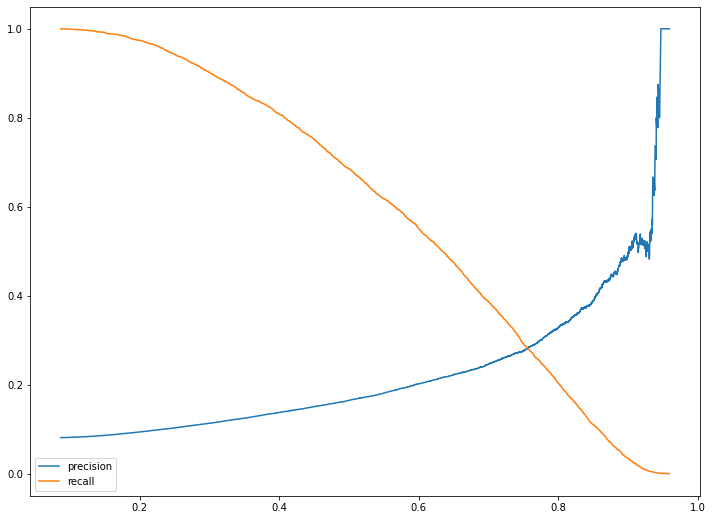

In [105]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC score: {:.2f}'.format(auc))
print('AVG Precision: {:.2f}'.format(
    average_precision_score(y_test, y_pred_proba[:,1])))
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba[:,1])

fig, ax = plt.subplots(figsize=(12,9))
ax.plot(threshold, precision[:-1], label='precision')
ax.plot(threshold, recall[:-1], label='recall')
ax.legend()
plt.show()

In [116]:
print(precision[np.argmin(np.abs(precision - recall))])
print(recall[np.argmin(np.abs(precision - recall))])

0.28187512628813904
0.28187512628813904


# 2021-10-05 : Définition du seuil précision / recall adéquat

Le seuil précision recall adéquat pour notre modèle est celui qui maximise le profit de l'organisme de crédit

En premier lieu il faut définir une métrique qui approxime le profit potentiel sur chaque demande de crédit.
On placera cette métrique dans une colonne `PROFIT`.
Cette métrique profit : 
* sera égale à 0 pour tous les prêts qui présentent un défaut de paiement (`TARGET = 1`)
* sera égale à aux intérêts (`AMT_INTEREST`) perçus pour les crédits biens remboursés (`TARGET = 0`)
    * la somme des intérêts est égale à la valeur du crédit moins la valeur du bien (`AMT_CREDIT` - `AMT_GOODS_PRICE`)
    * pour les cas où `AMT_GOODS_PRICE` >= `AMT_CREDIT`, `AMT_INTEREST` sera égal à `AMT_CREDIT` multiplié par le taux d'intérêt médian.

In [1]:
# Importations
import sys
sys.path.append('..')

# Bibliothèques utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitements
from preprocessing import preprocessor
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Machine Learning
from lightgbm import LGBMClassifier
from modelling_funcs import model_eval
from sklearn.metrics import recall_score, precision_score

from styles import *

In [2]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
#test = pd.read_csv('../02_data/application_test.csv')

print('Training set dimensions :', train.shape)
df = train.copy()

cls_size = df.TARGET.value_counts()
cls_freq = df.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.2f' % x)}))

Training set dimensions : (307511, 121)
     size  freq
0  282686  0.92
1   24825  0.08


In [4]:
# Définition du meilleur modèle trouvé jusqu'à présent
r = 42
undersampler = RandomUnderSampler(random_state=r)

best_model_params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8736655622105718,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 80,
 'min_child_weight': 100.0,
 'min_split_gain': 0.0,
 'n_estimators': 373,
 'n_jobs': -1,
 'num_leaves': 12,
 'objective': None,
 'random_state': r,
 'reg_alpha': 16,
 'reg_lambda': 21,
 'silent': True,
 'subsample': 0.7981160065359487,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

best_model = Pipeline([('u', undersampler),
                       ('p', preprocessor),
                       ('m', LGBMClassifier(**best_model_params))])

In [5]:
# Séparation du jeu de données entre entraînement et évaluation

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2,
                                                    random_state=r)

In [6]:
# 1ère évaluation du modèle
model_eval(best_model.fit(X_train, y_train), X_test, y_test)

[[39385 17169]
 [ 1559  3390]]
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.16      0.68      0.27      4949

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.76     61503

'model_eval': successfully processed in 0h00m03.465432s.


ROC AUC score: 0.69
AVG Precision: 0.24


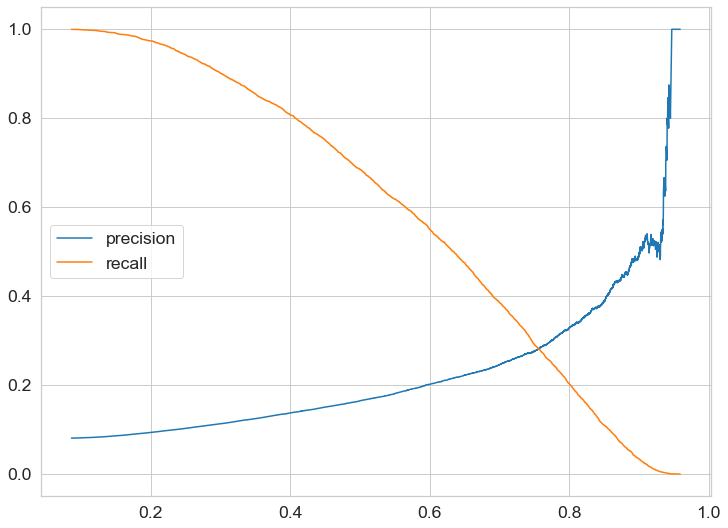

In [7]:
# Courbe precision recall indépendamment du profit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC score: {:.2f}'.format(auc))
print('AVG Precision: {:.2f}'.format(
    average_precision_score(y_test, y_pred_proba[:,1])))
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba[:,1])

fig, ax = plt.subplots(figsize=(12,9))
ax.plot(threshold, precision[:-1], label='precision')
ax.plot(threshold, recall[:-1], label='recall')
ax.legend()
plt.show()

In [10]:
# Définition des métriques d'intérêts et de taux d'intérêt

# Imputation des variables relatifs au crédit
from preprocessing import CreditInfosImputer
df = CreditInfosImputer().fit_transform(df)

# Définition d'une variable qui approxime le montant des intérêts des crédits
# Pour ceux dont la valeur du crédit est supérieure à la valeur du bien de conso
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_INTEREST'] = \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_CREDIT'] - \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_GOODS_PRICE']

# Définition d'une variable qui approxime le taux d'intérêt des crédits
# Pour ceux dont la valeur du crédit est supérieure à la valeur du bien de conso
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'INTEREST_RATE'] = \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_INTEREST'] / \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_CREDIT']

# Imputation du taux d'intérêt et de la somme des intérêts des crédits
# pour tous les autres cas
df.INTEREST_RATE.fillna(df.INTEREST_RATE.median(), inplace=True)
df.AMT_INTEREST.fillna(round(df.AMT_CREDIT * df.INTEREST_RATE, 0), inplace=True)

In [12]:
print(df.shape)
print(df.AMT_INTEREST.describe())
print(df.INTEREST_RATE.describe())

(307511, 123)
count    307511.000000
mean      87418.058130
std       62937.759157
min        2970.000000
25%       36920.000000
50%       71991.000000
75%      123066.000000
max      553798.000000
Name: AMT_INTEREST, dtype: float64
count    307511.000000
mean          0.148195
std           0.053540
min           0.023208
25%           0.126790
50%           0.136740
75%           0.165275
max           0.833333
Name: INTEREST_RATE, dtype: float64


In [23]:
df_test = df.loc[y_test.index]
df_test.loc[:, 'PREDICT'] = y_pred
df_test

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INTEREST,INTEREST_RATE,PREDICT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,418500.0,...,0,0.0,0.0,0.0,1.0,0.0,1.0,46957.5,0.100885,1
214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,1179000.0,...,0,0.0,0.0,0.0,1.0,0.0,3.0,102712.5,0.080137,0
142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,495000.0,...,0,0.0,0.0,0.0,1.0,0.0,3.0,67686.0,0.136740,1
389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,225000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,29700.0,0.116608,0
283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,234000.0,...,0,0.0,0.0,0.0,0.0,0.0,4.0,74133.0,0.240588,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396891,0,Revolving loans,M,Y,Y,2,450000.0,900000.0,45000.0,900000.0,...,0,0.0,0.0,0.0,0.0,1.0,1.0,123066.0,0.136740,0
423085,0,Cash loans,F,N,Y,0,225000.0,202500.0,24030.0,202500.0,...,0,0.0,0.0,0.0,1.0,1.0,3.0,27690.0,0.136740,1
356971,0,Cash loans,M,N,Y,0,121500.0,254700.0,30357.0,225000.0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,29700.0,0.116608,0


In [30]:
def correct(X):
    verdicts = []
    for idx in X.index:
        if X.loc[idx, 'TARGET'] == X.loc[idx, 'PREDICT']:
            verdict = 'gagné'
        else:
            verdict = 'perdu'
        verdicts.append(verdict)
    return verdicts

In [31]:
pd.DataFrame({'size': pd.Series(correct(df_test)).value_counts(),
              'freq': pd.Series(correct(df_test)).value_counts(normalize=True)})

,size,freq
gagné,42775,0.695495
perdu,18728,0.304505


In [35]:
def home_credit_profits(X):
    profits = []
    for idx in X.index:
        if X.loc[idx, 'PREDICT'] == 1:
            profit = 0.0
        elif X.loc[idx, 'PREDICT'] == 0 and X.loc[idx, 'TARGET'] == 0:
            profit = X.loc[idx, 'AMT_INTEREST']
        elif X.loc[idx, 'PREDICT'] == 0 and X.loc[idx, 'TARGET'] == 1:
            profit = - X.loc[idx, 'AMT_GOODS_PRICE']
        profits.append(profit)
    return profits

In [48]:
df_test.loc[:, 'PROFIT'] = home_credit_profits(df_test)
df_test.PROFIT.sum()

2566715877.0

In [49]:
df_test

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INTEREST,INTEREST_RATE,PREDICT,PROFIT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,418500.0,...,0.0,0.0,0.0,1.0,0.0,1.0,46957.5,0.100885,1,0.0
214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,1179000.0,...,0.0,0.0,0.0,1.0,0.0,3.0,102712.5,0.080137,0,102712.5
142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,495000.0,...,0.0,0.0,0.0,1.0,0.0,3.0,67686.0,0.136740,1,0.0
389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,225000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29700.0,0.116608,0,29700.0
283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,234000.0,...,0.0,0.0,0.0,0.0,0.0,4.0,74133.0,0.240588,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396891,0,Revolving loans,M,Y,Y,2,450000.0,900000.0,45000.0,900000.0,...,0.0,0.0,0.0,0.0,1.0,1.0,123066.0,0.136740,0,123066.0
423085,0,Cash loans,F,N,Y,0,225000.0,202500.0,24030.0,202500.0,...,0.0,0.0,0.0,1.0,1.0,3.0,27690.0,0.136740,1,0.0
356971,0,Cash loans,M,N,Y,0,121500.0,254700.0,30357.0,225000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,29700.0,0.116608,0,29700.0


In [53]:
print(threshold[np.argmin(np.abs(precision - recall))])

0.7560445445897188


In [70]:
# Fonction de modèle final avec un seuil de décision paramétrable
def final_model(model, X, threshold=0.5):
    return np.array(model.predict_proba(X)[:,1] > threshold, dtype=int)

In [71]:
final_model(best_model, X_test)

array([1, 0, 1, ..., 0, 0, 0])

In [75]:
assert (np.asarray(df_test.PREDICT) == final_model(best_model, X_test)).all()

In [76]:
def get_profit_curve(threshold):
    total_profits = []
    for t in threshold:
        df_test.loc[:, 'PREDICT'] = final_model(best_model, X_test, threshold=t)
        total_profit = sum(home_credit_profits(df_test))
        total_profits.append(total_profit)
    return total_profits

In [98]:
gross_profit_curve = get_profit_curve(threshold[::1000])

In [101]:
len(gross_profit_curve)

62

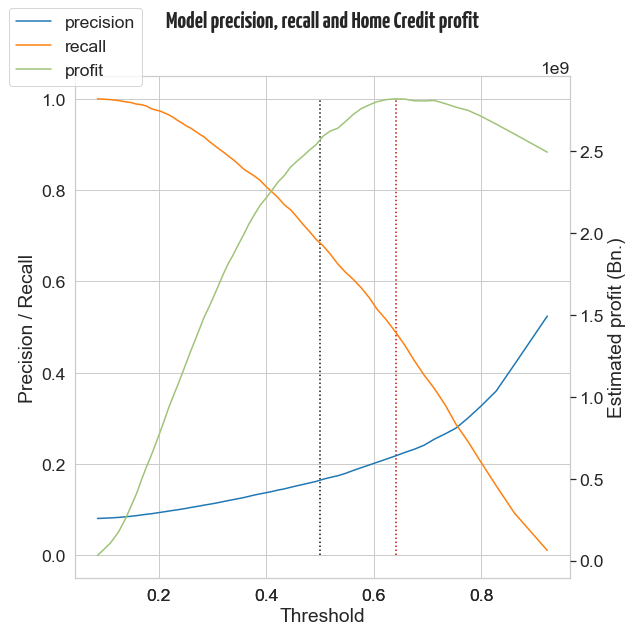

In [130]:
fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(111)
ax1.plot(threshold[::1000], precision[::1000], label='precision',)
ax1.plot(threshold[::1000], recall[::1000], label='recall')
ax1.set_ylabel('Precision / Recall')
ax1.set_xlabel('Threshold')
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.plot(threshold[::1000], gross_profit_curve, label='profit', color='g')
ax2.grid(None)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Estimated profit (Bn.)')
ax1.vlines([.5, threshold[::1000][np.argmax(gross_profit_curve)]], 0, 1,
           colors=['k', 'r'], linestyle=':')
fig.legend(loc='upper left')
fig.suptitle('Model precision, recall and Home Credit profit',
             **title_font)
fig.tight_layout()
plt.show()

In [115]:
ideal_threshold = threshold[::1000][np.argmax(gross_profit_curve)]
ideal_threshold_precision = precision[::1000][np.argmax(gross_profit_curve)]
ideal_threshold_recall = recall[::1000][np.argmax(gross_profit_curve)]
print('Ideal threshold: {:.2f}'.format(ideal_threshold))
print('Precision level: {:.2f}'.format(ideal_threshold_precision))
print('Recall level: {:.2f}'.format(ideal_threshold_recall))

Ideal threshold: 0.64
Precision level: 0.22
Recall level: 0.49


In [116]:
# Évaluation de la performance de classification sur le modèle final
from sklearn.metrics import confusion_matrix, classification_report

y_pred_final = final_model(best_model, X_test, threshold=ideal_threshold)
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

[[47872  8682]
 [ 2529  2420]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     56554
           1       0.22      0.49      0.30      4949

    accuracy                           0.82     61503
   macro avg       0.58      0.67      0.60     61503
weighted avg       0.89      0.82      0.85     61503



# 2021-10-06 : Création d'un objet classifieur final

In [1]:
# Importations
import sys
sys.path.append('..')

# Bibliothèques utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitements
from preprocessing import preprocessor
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Machine Learning
from lightgbm import LGBMClassifier
from modelling_funcs import model_eval
from sklearn.metrics import recall_score, precision_score

from styles import *

In [3]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
#test = pd.read_csv('../02_data/application_test.csv')

print('Training set dimensions :', train.shape)
df = train.copy()

cls_size = df.TARGET.value_counts()
cls_freq = df.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.2f' % x)}))

Training set dimensions : (307511, 121)
     size  freq
0  282686  0.92
1   24825  0.08


In [4]:
# Séparation du jeu de données entre entraînement et évaluation
r = 42
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2,
                                                    random_state=r)

In [5]:
# Définition du meilleur modèle trouvé jusqu'à présent
r = 42

best_model_params = {'boosting_type': 'gbdt',
                     'class_weight': None,
                     'colsample_bytree': 0.8736655622105718,
                     'importance_type': 'split',
                     'learning_rate': 0.1,
                     'max_depth': -1,
                     'min_child_samples': 80,
                     'min_child_weight': 100.0,
                     'min_split_gain': 0.0,
                     'n_estimators': 373,
                     'n_jobs': -1,
                     'num_leaves': 12,
                     'objective': None,
                     'random_state': r,
                     'reg_alpha': 16,
                     'reg_lambda': 21,
                     'silent': True,
                     'subsample': 0.7981160065359487,
                     'subsample_for_bin': 200000,
                     'subsample_freq': 0}

undersampler = RandomUnderSampler(random_state=r)

best_model = Pipeline([('u', undersampler),
                       ('p', preprocessor),
                       ('m', LGBMClassifier(**best_model_params))])

# 2021-10-07 : Sérialisation du modèle

In [14]:
# Importations
import sys
sys.path.append('..')

# Bibliothèques utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitements
from preprocessing import preprocessor
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Machine Learning
from lightgbm import LGBMClassifier
from modelling_funcs import model_eval
from sklearn.metrics import recall_score, precision_score

from styles import *

In [2]:
# Initialisation
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
test = pd.read_csv('../02_data/application_test.csv', index_col=0)

print('Training set dimensions :', train.shape)
df = train.copy()

cls_size = df.TARGET.value_counts()
cls_freq = df.TARGET.value_counts(normalize=True)
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.2f' % x)}))

Training set dimensions : (307511, 121)
     size  freq
0  282686  0.92
1   24825  0.08


In [10]:
# Séparation du jeu de données entre entraînement et évaluation
#r = 42
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2)
#                                                     random_state=r)

In [15]:
undersampler = RandomUnderSampler()

best_model_params = {'boosting_type': 'gbdt',
                     'class_weight': None,
                     'colsample_bytree': 0.8736655622105718,
                     'importance_type': 'split',
                     'learning_rate': 0.1,
                     'max_depth': -1,
                     'min_child_samples': 80,
                     'min_child_weight': 100.0,
                     'min_split_gain': 0.0,
                     'n_estimators': 373,
                     'n_jobs': -1,
                     'num_leaves': 12,
                     'objective': None,
                     'random_state': None,
                     'reg_alpha': 16,
                     'reg_lambda': 21,
                     'silent': True,
                     'subsample': 0.7981160065359487,
                     'subsample_for_bin': 200000,
                     'subsample_freq': 0}

model = Pipeline([('u', undersampler),
                  ('p', preprocessor),
                  ('m', LGBMClassifier(**best_model_params))])

In [16]:
model.fit(X_train, y_train)

Pipeline(steps=[('u', RandomUnderSampler()),
                ('p',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('creditinfosimputer',
                                                  CreditInfosImputer(),
                                                  ['AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE']),
                                                 ('carinfosimputer',
                                                  CarInfosImputer(),
                                                  ['FLAG_OWN_CAR',
                                                   'OWN_CAR_AGE']),
                                                 ('simpleimputer-1',
                                                  SimpleImputer(strategy='median'),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL'...
           

In [17]:
model_eval(model, X_test, y_test)

[[39351 16996]
 [ 1646  3510]]
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56347
           1       0.17      0.68      0.27      5156

    accuracy                           0.70     61503
   macro avg       0.57      0.69      0.54     61503
weighted avg       0.89      0.70      0.76     61503

'model_eval': successfully processed in 0h00m02.214229s.


In [19]:
test.shape

(48744, 120)

In [20]:
test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
pred_test = model.predict(test)
print(pred_test.shape)
print(pred_test)

(48744,)
[0 1 0 ... 0 0 1]


In [ ]:
import joblib

joblib.dump(model, 'HomeCredit_DefaultRiskModel')

## Import de la fonction sérialisée

In [1]:
# Importations
import sys
sys.path.append('..')

import dill
import pandas as pd
import numpy as np

with open('../HomeCredit_DefaultRiskModel', 'rb') as model_file:
    model = dill.load(model_file)

test = pd.read_csv('../02_data/application_test.csv', index_col=0)

In [2]:
print('Testing set dimensions:', test.shape)
test.head()

Testing set dimensions: (48744, 120)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
probas = model.predict_proba(test)
print(probas.shape)
print(probas)

(48744, 2)
[[0.65438632 0.34561368]
 [0.40950682 0.59049318]
 [0.78411042 0.21588958]
 ...
 [0.70896753 0.29103247]
 [0.51278689 0.48721311]
 [0.24358748 0.75641252]]


# 2021-10-08 : Réajustements courbe de profit % modèle final

In [1]:
# Importations
import sys
sys.path.append('..')

# Bibliothèques utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du modèle de prédiction sérialisé
import joblib
model = joblib.load('../HomeCredit_DefaultRisk.pkl')

# Évaluation
from sklearn.model_selection import train_test_split
from modelling_funcs import model_eval
from sklearn.metrics import recall_score, precision_score

from styles import *

In [2]:
# Chargement des jeux de données d'apprentissage et de test
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
test = pd.read_csv('../02_data/application_test.csv', index_col=0)

print('Training set dimensions :', train.shape)
df = train.copy()

cls_size = df.TARGET.value_counts()
cls_freq = df.TARGET.value_counts(normalize=True)
print('Learning set:')
print(pd.DataFrame({'size': cls_size,
                    'freq': cls_freq.apply(lambda x: '%.2f' % x)}))

Training set dimensions : (307511, 121)
Learning set:
     size  freq
0  282686  0.92
1   24825  0.08


In [3]:
# Séparation du jeu de données d'apprentissage entre entraînement et évaluation

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2,)
#                                                    random_state=r)

In [4]:
# Définition des métriques d'intérêts et de taux d'intérêt

# Imputation des variables relatifs au crédit
from preprocessing import CreditInfosImputer
df = CreditInfosImputer().fit_transform(df)

# Définition d'une variable qui approxime le montant des intérêts des crédits
# Pour ceux dont la valeur du crédit est supérieure à la valeur du bien de conso
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_INTEREST'] = \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_CREDIT'] - \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_GOODS_PRICE']

# Définition d'une variable qui approxime le taux d'intérêt des crédits
# Pour ceux dont la valeur du crédit est supérieure à la valeur du bien de conso
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'INTEREST_RATE'] = \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_INTEREST'] / \
df.loc[df.AMT_CREDIT > df.AMT_GOODS_PRICE, 'AMT_CREDIT']

# Imputation du taux d'intérêt et de la somme des intérêts des crédits
# pour tous les autres cas
df.INTEREST_RATE.fillna(df.INTEREST_RATE.median(), inplace=True)
df.AMT_INTEREST.fillna(round(df.AMT_CREDIT * df.INTEREST_RATE, 0), inplace=True)

In [5]:
df_test = df.loc[y_test.index]
df_test.loc[:, 'PREDICT'] = model.predict(X_test)
df_test

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INTEREST,INTEREST_RATE,PREDICT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
179102,0,Revolving loans,M,Y,Y,1,178200.0,270000.0,13500.0,270000.0,...,0,0.0,0.0,0.0,0.0,0.0,2.0,36920.0,0.136740,0
279312,0,Cash loans,M,Y,Y,0,90000.0,521280.0,22216.5,450000.0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,71280.0,0.136740,0
197250,0,Cash loans,M,Y,N,1,184500.0,1724220.0,45612.0,1350000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,374220.0,0.217037,0
317259,1,Revolving loans,F,N,Y,0,90000.0,180000.0,9000.0,180000.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,24613.0,0.136740,1
249286,0,Cash loans,M,Y,Y,2,180000.0,284400.0,19003.5,225000.0,...,0,0.0,0.0,0.0,0.0,0.0,2.0,59400.0,0.208861,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211637,0,Cash loans,F,Y,N,0,225000.0,1213227.0,48244.5,1116000.0,...,0,0.0,0.0,0.0,1.0,0.0,1.0,97227.0,0.080139,0
304310,0,Cash loans,F,N,Y,0,157500.0,305640.0,33043.5,270000.0,...,0,0.0,0.0,0.0,0.0,0.0,4.0,35640.0,0.116608,0
382456,0,Cash loans,M,N,Y,1,292500.0,1166724.0,34245.0,913500.0,...,0,0.0,0.0,0.0,0.0,1.0,4.0,253224.0,0.217038,0


ROC AUC score: 0.71
AVG Precision: 0.25


TypeError: 'dict' object is not callable

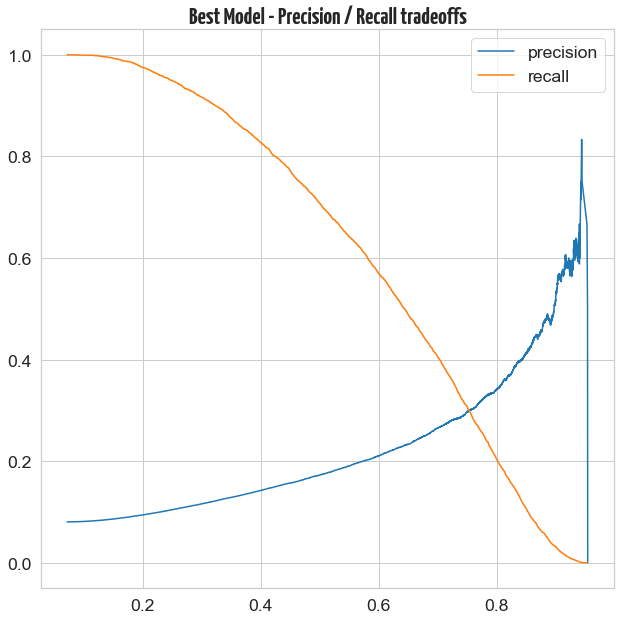

In [13]:
# Courbe precision recall indépendamment du profit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC score: {:.2f}'.format(auc))
print('AVG Precision: {:.2f}'.format(
    average_precision_score(y_test, y_pred_proba[:,1])))
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba[:,1])

fig, ax = plt.subplots(figsize=(9,9))
ax.plot(threshold, precision[:-1], label='precision')
ax.plot(threshold, recall[:-1], label='recall')
ax.legend()
ax.set_title('Best Model - Precision / Recall tradeoffs', **title_font)
fig.tight_layout()
savefig(fig, 'precision_recall_tradeoffs.png')
plt.show()

In [7]:
# Fonction de modèle final avec un seuil de décision paramétrable
def final_model(model, X, threshold=0.5):
    return np.array(model.predict_proba(X)[:,1] > threshold, dtype=int)

In [8]:
def home_credit_profits(X):
    profits = []
    for idx in X.index:
        if X.loc[idx, 'PREDICT'] == 1:
            profit = 0.0
        elif X.loc[idx, 'PREDICT'] == 0 and X.loc[idx, 'TARGET'] == 0:
            profit = X.loc[idx, 'AMT_INTEREST']
        elif X.loc[idx, 'PREDICT'] == 0 and X.loc[idx, 'TARGET'] == 1:
            profit = - X.loc[idx, 'AMT_GOODS_PRICE']
        profits.append(profit)
    return profits

In [9]:
def get_profit_curve(threshold):
    total_profits = []
    for t in threshold:
        df_test.loc[:, 'PREDICT'] = final_model(model, X_test, threshold=t)
        total_profit = sum(home_credit_profits(df_test))
        total_profits.append(total_profit)
    df_test.loc[:, 'PREDICT'] = final_model(model, X_test)
    return total_profits

In [10]:
gross_profit_curve = get_profit_curve(threshold[::1000])
print(len(gross_profit_curve), 'situations tested.')

62 situations tested.


In [20]:
# Calcul du profit réalisé dans le cas où aucun dossier ne serait refusé
df_test.loc[:, 'PREDICT'] = np.array([0] * df_test.shape[0])
baseline_profit = sum(home_credit_profits(df_test))
print(baseline_profit)

2550117586.5


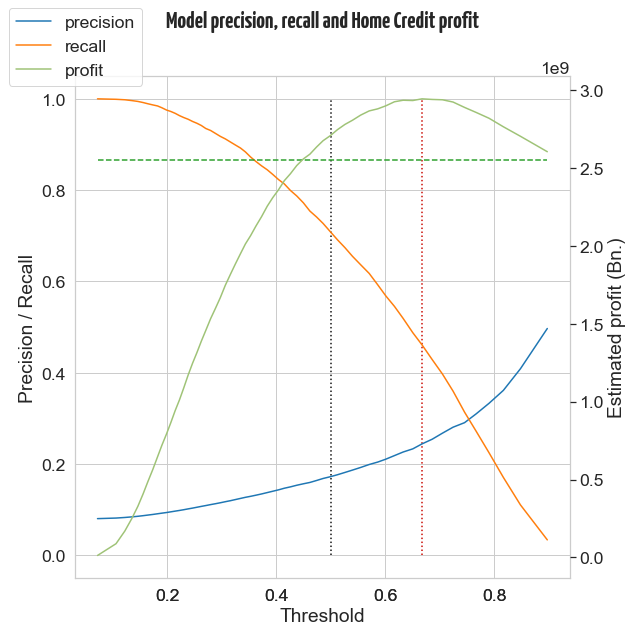

In [26]:
fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(111)
ax1.plot(threshold[::1000], precision[::1000], label='precision',)
ax1.plot(threshold[::1000], recall[::1000], label='recall')
ax1.set_ylabel('Precision / Recall')
ax1.set_xlabel('Threshold')
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.plot(threshold[::1000], gross_profit_curve, label='profit', color='g')
ax2.grid(None)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Estimated profit (Bn.)')
ax1.vlines([.5, threshold[::1000][np.argmax(gross_profit_curve)]], 0, 1,
           colors=['k', 'r'], linestyle=':')
ax2.hlines([baseline_profit], threshold[::1000][0], threshold[::1000][-1],
           colors =['tab:green'], linestyle='--')
fig.legend(loc='upper left')
fig.suptitle('Model precision, recall and Home Credit profit',
             **title_font)
fig.tight_layout()
figsave(fig, 'gross_profit_curve.png')
plt.show()

In [17]:
np.array([0] * df_test.shape[0]).shape

(61503,)

In [14]:
ideal_threshold = threshold[::1000][np.argmax(gross_profit_curve)]
print(ideal_threshold)

0.6672414786824148


# 2021-10-11 : Explicabilité du modèle

In [1]:
# Importations
import sys
sys.path.append('..')

# Bibliothèques utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Explicabilité
import shap

# Modélisation
import joblib
model = joblib.load('../HomeCredit_DefaultRisk.pkl')
from sklearn.model_selection import train_test_split

# Autres
from styles import *

In [2]:
# Chargement des jeux de données d'apprentissage et de test
train = pd.read_csv('../02_data/application_train.csv', index_col=0)
test = pd.read_csv('../02_data/application_test.csv', index_col=0)

print('Training set dimensions :', train.shape)
df = train.copy()

# Séparation du jeu de données d'apprentissage entre entraînement et évaluation

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0],
                                                    test_size=.2,)

Training set dimensions : (307511, 121)


In [3]:
from preprocessing import get_preprocessed_set_column_names
feature_names = get_preprocessed_set_column_names(model['p'])
print(feature_names)

['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'FLAG_OWN_CAR', 'OWN_CAR_AGE', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',

In [4]:


model['m'].feature_importances_
shap.summary_plot()

TypeError: summary_legacy() missing 1 required positional argument: 'shap_values'

In [58]:
X, y = (df.iloc[:,1:], df.iloc[:,0])

In [59]:
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
456252,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
456253,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0


In [60]:
explainer = shap.Explainer(model['m'])
shap_values = explainer(model['p'].transform(X))

In [9]:
assert len(feature_names) == model['m'].feature_importances_.shape[0]

In [20]:
tree_explainer = shap.TreeExplainer(model['m'])

In [57]:
shap_values = tree_explainer(model['p'].transform(df.iloc[:,1:]))

NameError: name 'tree_explainer' is not defined

In [54]:
shap_values

.values =
array([[[ 0.28570183, -0.28570183],
        [ 0.00281822, -0.00281822],
        [-0.19015088,  0.19015088],
        ...,
        [ 0.00385244, -0.00385244],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-0.00307586,  0.00307586],
        [-0.04160534,  0.04160534],
        [ 0.47862565, -0.47862565],
        ...,
        [ 0.0089029 , -0.0089029 ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-0.22081019,  0.22081019],
        [-0.00268294,  0.00268294],
        [ 0.03251638, -0.03251638],
        ...,
        [ 0.00562258, -0.00562258],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       ...,

       [[ 0.50739749, -0.50739749],
        [ 0.02500549, -0.02500549],
        [-0.16335271,  0.16335271],
        ...,
        [-0.02665633,  0.02665633],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.28164531, -0.28164531],
        [ 0.05579

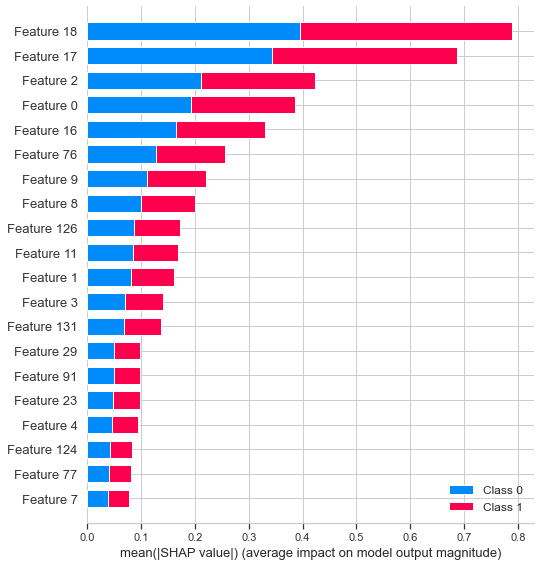

In [5]:
tree_explainer = shap.TreeExplainer(model['m'])
shap_values = tree_explainer.shap_values(model['p'].transform(X_test))
shap.summary_plot(shap_values, model['p'].transform(X_test))

In [47]:
shap_values.values[:,:,1].shape

(61503, 235)

In [44]:
model['p'].transform(X_test).shape

(61503, 235)

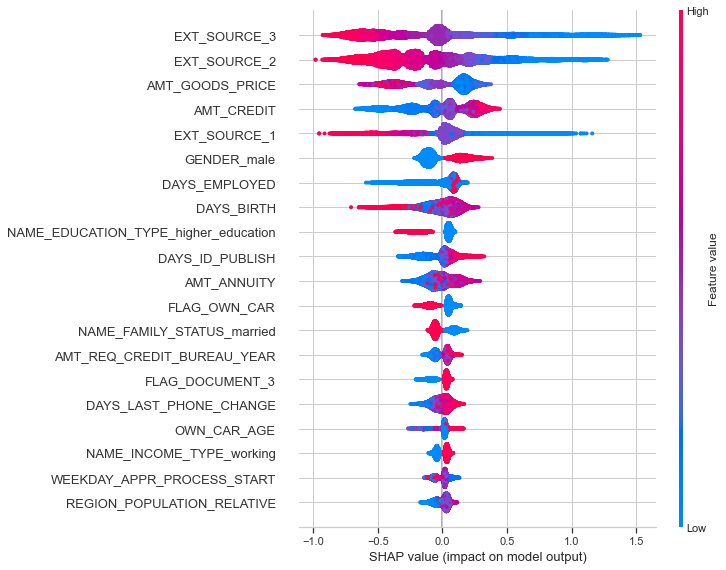

In [55]:
shap.summary_plot(shap_values.values[:,:,1], model['p'].transform(X_test),
                  feature_names=feature_names)

In [10]:
for i in range(len(feature_names)):
    if feature_names[i] == 'CODE_GENDER':
        feature_names[i] = 'GENDER_male'
    elif feature_names[i] == 'NAME_CONTRACT_TYPE':
        feature_names[i] = 'CONTRACT_TYPE_revolving_loan'

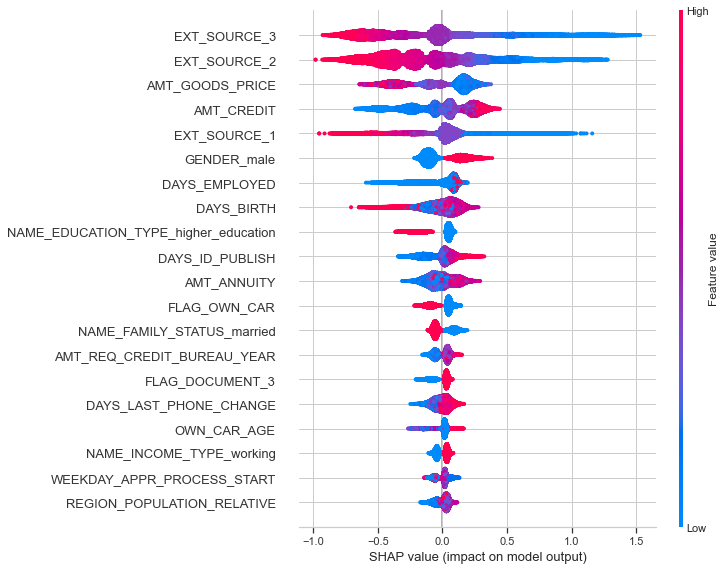

In [11]:
shap.summary_plot(shap_values[1], model['p'].transform(X_test),
                  feature_names=feature_names)

In [14]:
shap_values[1]

array([[-0.28570183, -0.00281822,  0.19015088, ..., -0.00385244,
         0.        ,  0.        ],
       [ 0.00307586,  0.04160534, -0.47862565, ..., -0.0089029 ,
         0.        ,  0.        ],
       [ 0.22081019,  0.00268294, -0.03251638, ..., -0.00562258,
         0.        ,  0.        ],
       ...,
       [-0.50739749, -0.02500549,  0.16335271, ...,  0.02665633,
         0.        ,  0.        ],
       [-0.28164531, -0.05579448,  0.16696178, ..., -0.00356778,
         0.        ,  0.        ],
       [ 0.0670506 ,  0.04179625, -0.08352903, ..., -0.00925769,
         0.        ,  0.        ]])

In [51]:
type(tree_explainer.expected_value[1])

numpy.float64

In [56]:
shap.plots.waterfall(explainer, shap_values[1],
                     model['p'].transform(X))

AttributeError: 'Tree' object has no attribute 'base_values'

In [28]:
shap.force_plot(tree_explainer.expected_value[1], shap_values[1])

MemoryError: Unable to allocate 14.1 GiB for an array with shape (1891278753,) and data type float64

In [26]:
tree_explainer.expected_value

[-0.0065363257503529065, 0.0065363257503529065]